In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Module, Sequential, Linear, Conv2d, ReLU, Tanh, Dropout, BatchNorm1d
from torch.utils.data import DataLoader
from torch import optim

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from torch.distributions.multivariate_normal import MultivariateNormal

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
load_size = 5000   #len: 5918
num_samples_train = load_size

transform = transforms.Compose([
    #transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

train_dataset.data = train_dataset.data[train_dataset.targets == 6]
train_dataset.targets = train_dataset.targets[train_dataset.targets == 6]

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=load_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=load_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

2.0%

100.0%


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100.0%


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw




100.0%
100.0%


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



In [4]:
class v_model(Module):
    def __init__(self, input_dim, layers, hidden_num):
        super().__init__()
        self.input_dim = input_dim
        self.input_dim = hidden_num

        p_drop = 0.2
        self.NN = Sequential(Linear(input_dim + 1, hidden_num, bias=True),
                            ReLU(),
                            BatchNorm1d(hidden_num)
                            )

        for layer in range(layers):
            self.NN.append(Dropout(p_drop))
            self.NN.append(Linear(hidden_num, hidden_num, bias=True))
            self.NN.append(ReLU())
            self.NN.append(BatchNorm1d(hidden_num))
        self.NN.append(Dropout(p_drop))
        self.NN.append(Linear(hidden_num, input_dim, bias=True))


    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.NN(inputs)

        return x

In [5]:
class RectifiedFlow(Module):
    def __init__(self, v_model):
        super().__init__()
        self.v_model = v_model.to(device)
        self.loss_curve = []

    def get_train_tuple(self, z0, z1):
        # random times
        t = torch.rand((z0.shape[0], 1)).to(device)
        # linear interpolation
        z_t = t* z1 + (1-t) * z0
        # connection line
        target = z1 - z0

        return z_t, t, target

    @torch.no_grad()
    def sample_ode(self, z0, num_steps):
        trajectory = []
        trajectory.append(z0.detach().clone())

        batchsize = z0.shape[0]

        dt = 1./num_steps
        z = z0.detach().clone()
        for i in range(num_steps):
            t = torch.ones((batchsize, 1)).to(device) * i /num_steps
            pred = self.v_model(z, t)
            z = z.detach().clone() + pred * dt

            trajectory.append(z.detach().clone())

        return trajectory

    def reverse_sample_ode(self, z1, num_steps):
        trajectory = []
        trajectory.append(z1.detach().clone())

        batchsize = z1.shape[0]

        dt = 1./num_steps
        z = z1.detach().clone()
        for i in range(num_steps):
            t = torch.ones((batchsize, 1)).to(device) * i /num_steps
            pred = self.v_model(z, 1 - t)
            z = z.detach().clone() - (pred * dt)

            trajectory.append(z.detach().clone())

        return trajectory

In [6]:
def train_rectified_flow(rectified_flow, optimizer, scheduler, z1, batchsize, iterations):
    loss_curve = rectified_flow.loss_curve
    rectified_flow.v_model.train()
    for i in range(iterations + 1):
        optimizer.zero_grad()
        indeces = torch.randperm(len(z1))[:batchsize]
        z1 = z1[indeces]
        z0 = torch.randn(z1.shape).to(device) * 1/3

        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)

        pred = rectified_flow.v_model(z_t, t)
        loss = (target- pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
        loss = loss.mean()
        loss.backward()

        optimizer.step()
        loss_curve.append(loss.item())
        scheduler.step(loss.item())

        # plt.imshow(z1[0].reshape(28,28).detach().cpu().numpy())
        # plt.show()
        # plt.imshow(z0[0].reshape(28,28).detach().cpu().numpy())
        # plt.show()
        # print(t[0])
        # plt.imshow(z_t[0].reshape(28,28).detach().cpu().numpy())
        # plt.show()
        # plt.imshow(target[0].reshape(28,28).detach().cpu().numpy())
        # plt.show()
        # plt.imshow(pred[0].reshape(28,28).detach().cpu().numpy())
        # plt.show()

    rectified_flow.loss_curve = loss_curve
    return rectified_flow, loss_curve

In [7]:
train_dataset_target = None
for batch in train_dataloader:
    train_dataset_target = batch[0].reshape(-1, 28*28).to(device)
    break
print(train_dataset_target.shape)

torch.Size([5000, 784])


[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -0.7019608
   0.12941182  0.14509809 -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.       

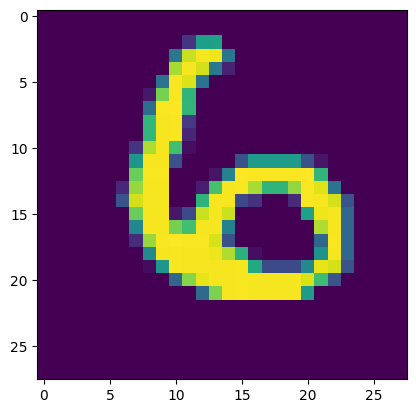

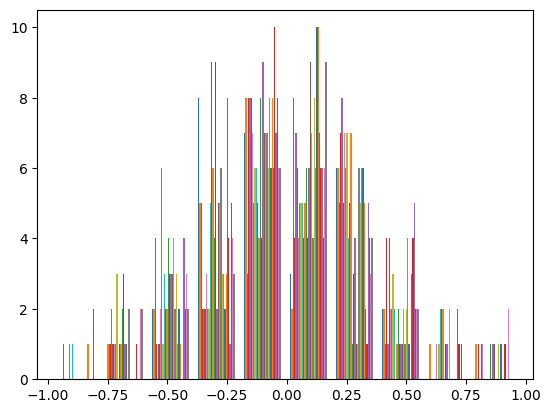

[[-2.64579326e-01 -6.95591373e-03 -2.56954461e-01 -7.76973963e-02
   7.36663342e-02 -1.42502293e-01 -5.00568561e-02  2.31800601e-01
   9.50272679e-02  1.97639167e-01 -2.65574306e-01  2.94612329e-02
   5.46369195e-01 -3.38658363e-01  8.90274584e-01  2.41664401e-03
   1.70708314e-01 -3.94422978e-01  4.42174226e-01 -3.29199046e-01
   4.39187139e-01  2.51427382e-01 -3.30665737e-01  5.13636053e-01
   1.35946320e-02  1.49015650e-01 -3.40169340e-01  3.21713001e-01]
 [-8.96023437e-02  1.80053577e-01 -1.50645107e-01 -6.10055447e-01
   3.13088179e-01 -6.46285474e-01 -2.51293438e-03  4.45061177e-02
   4.96279716e-01 -1.07251883e-01 -4.87498760e-01 -1.09098172e-02
  -6.03492320e-01 -2.92152703e-01 -3.96624118e-01  1.18135393e-01
  -3.94670889e-02 -7.05040395e-01 -1.48387685e-01 -3.07168692e-01
   2.64149103e-02  1.59522071e-01 -2.71345764e-01  4.18612719e-01
  -7.12604448e-02  6.38236463e-01 -4.03943986e-01 -2.30594620e-01]
 [-2.57773042e-01  2.19430670e-01  6.59587383e-02 -7.49373138e-02
  -1.109

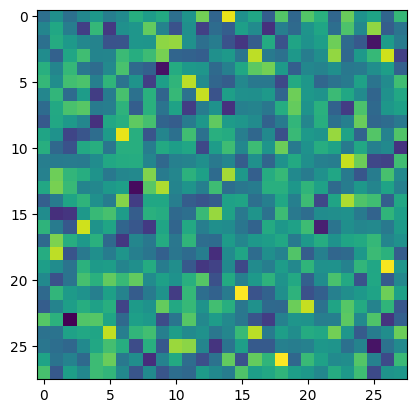

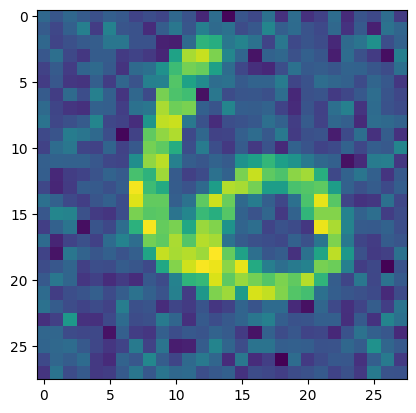

In [8]:
d = train_dataset_target[0].reshape(28,28).cpu().numpy()
plt.imshow(d)
print(d)
plt.show()
p = torch.randn((28,28)).cpu().numpy() * 1/3
plt.hist(p)
plt.show()
print(p)
plt.imshow(p)
plt.show()
plt.imshow(d - p)

In [9]:
v_mod = v_model(input_dim=28*28,layers=10, hidden_num=32*64)
rectified_flow_1 = RectifiedFlow(v_mod)

In [10]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-4)
scheduler_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=100, verbose=False)

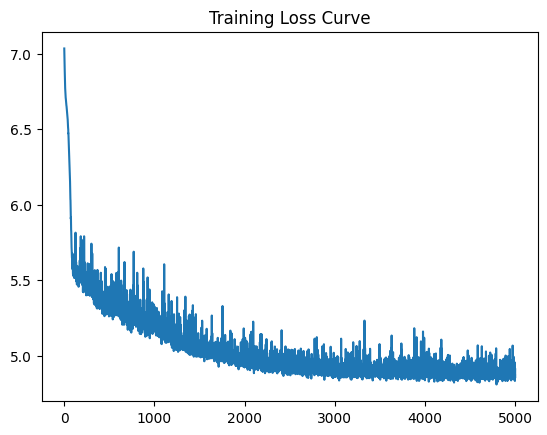

In [11]:
rectified_flow_1, loss_curve_1 = train_rectified_flow(rectified_flow_1, optimizer_1, scheduler_1, train_dataset_target, batchsize=512, iterations=5000)
plt.plot(np.log(loss_curve_1))
plt.title("Training Loss Curve")
plt.show()

164.9718048661432
122.64764404296875


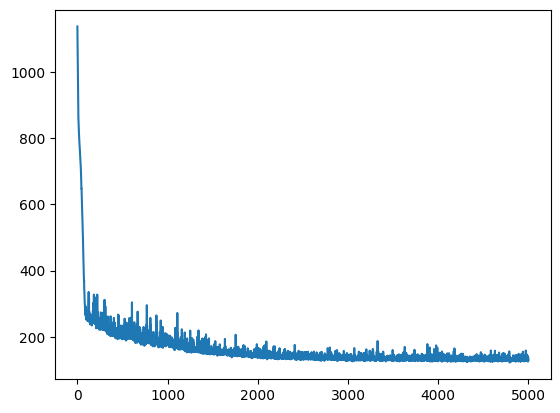

In [13]:
plt.plot(rectified_flow_1.loss_curve)
print(np.mean(rectified_flow_1.loss_curve[:-200]))
print(np.min(rectified_flow_1.loss_curve))

In [14]:

samples = torch.randn(train_dataset_target.shape)[:100].to(device) * 1/3

--initial:
tensor(-0.0010, device='cuda:0')
tensor(0.3338, device='cuda:0')
--target:
tensor(-0.7255, device='cuda:0')
tensor(0.6297, device='cuda:0')
--learned:
tensor(-0.7434, device='cuda:0')
tensor(0.6552, device='cuda:0')
tensor([[-0.6811, -1.4907, -1.1937, -1.1801, -0.7913, -0.5763, -1.1118, -1.0380,
         -1.1994, -0.9092, -1.0257, -1.1948, -0.9396, -1.0789, -0.8561, -1.1431,
         -0.6210, -1.5292, -1.1543, -0.9187, -1.4538, -0.8605, -0.5844, -1.2841,
         -0.8832, -1.2466, -0.6818, -0.2062],
        [-0.8860, -1.1489, -1.4192, -1.2454, -0.9995, -1.0238, -0.7263, -0.6350,
         -1.3302, -1.2840, -0.8777, -1.1956, -1.4543, -1.0876, -0.8258, -0.7636,
         -0.9454, -1.1068, -1.1684, -1.5302, -1.3123, -1.4719, -0.8807, -0.4630,
         -0.9396, -0.9541, -0.5750, -1.1022],
        [-1.3374, -0.5646, -0.9092, -0.9608, -1.2844, -0.7891, -1.0895, -1.0007,
         -0.7494, -0.7585, -0.3564,  0.1463,  0.1352, -0.4794, -1.0196, -1.2484,
         -0.9068, -1.0659, -0.572

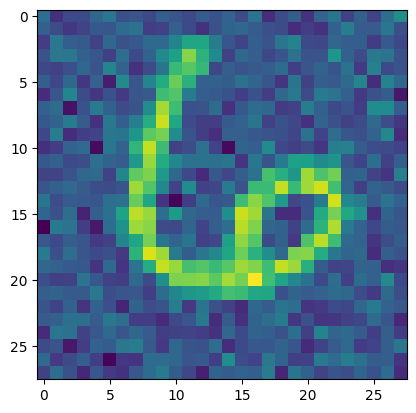

In [59]:
import cv2

curr_img = 0
rectified_flow_1.v_model.eval()
#samples = train_dataset_target[:100].to(device)
img = rectified_flow_1.sample_ode(samples, 100)
a = img[-1][curr_img].resize(28,28).detach().cpu().numpy()
a = a / np.max(a) * 255
a = a.astype(np.uint8)

#print(a)

#a = cv2.fastNlMeansDenoising(a, templateWindowSize=5, searchWindowSize=13)

print("--initial:")
print(torch.mean(samples))
print(torch.std(samples))
print("--target:")
print(torch.mean(train_dataset_target))
print(torch.std(train_dataset_target))
print("--learned:")
print(torch.mean(img[-1][:]))
print(torch.std(img[-1][:]))
plt.imshow(img[-1][curr_img].reshape(28,28).detach().cpu().numpy())
print(img[-1][curr_img].reshape(28,28))
plt.show()

In [19]:
# train_dataset_init=(normal_init.sample([num_samples_train]).to(device).reshape(-1, 32*32))
# train_dataset_init = torch.where(train_dataset_init < -1, -1, train_dataset_init)
# train_dataset_init = torch.where(train_dataset_init > 1, 1, train_dataset_init)

train_dataset_init = torch.randn(train_dataset_target.shape).to(device)

flow_1 = rectified_flow_1.sample_ode(train_dataset_init, 100)
#pairs_2 = torch.stack([train_dataset_init, flow_1[-1]], axis=1)

In [20]:
v_mod_2 = v_model(input_dim=28*28,layers=10, hidden_num=32*64)
rectified_flow_2 = RectifiedFlow(v_mod_2)

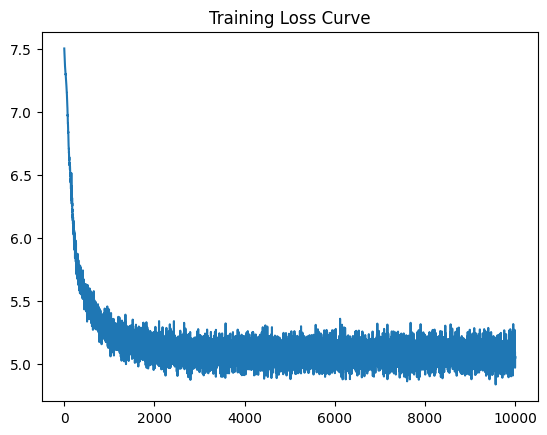

In [22]:
optimizer_2 = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-4)
scheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, factor=0.8, patience=100, verbose=False)

rectified_flow_2, loss_curve_2 = train_rectified_flow(rectified_flow_2, optimizer_2, scheduler_2, flow_1[-1],batchsize=256, iterations=10000)
plt.plot(np.log(loss_curve_2))
plt.title("Training Loss Curve")
plt.show()

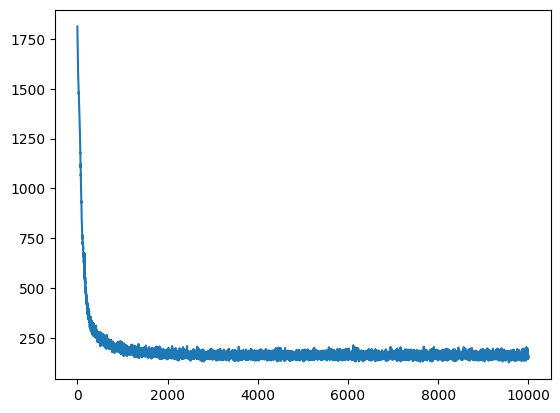

In [23]:
plt.plot(rectified_flow_2.loss_curve)

--initial:
tensor(0.0016, device='cuda:0')
tensor(0.3341, device='cuda:0')
--target:
tensor(-0.7256, device='cuda:0')
tensor(0.6294, device='cuda:0')
--learned:
tensor(-0.7332, device='cuda:0')
tensor(1.0666, device='cuda:0')
tensor([[-1.4671e+00, -2.1158e+00, -1.9689e+00, -1.0699e+00, -1.0246e+00,
         -2.9577e+00, -2.5320e+00,  7.3459e-01, -2.0486e+00, -1.7150e+00,
         -2.2384e+00, -3.0431e+00, -3.0080e+00, -1.4352e+00,  1.0573e+00,
         -1.0567e+00, -1.1929e+00, -1.2352e+00,  1.1839e-01,  1.0378e+00,
         -1.2335e-01, -2.0842e-01, -2.4081e+00,  4.4578e-01, -2.6244e-01,
         -1.2219e+00, -2.0574e+00, -9.8322e-01],
        [-1.2625e+00, -1.5776e+00, -2.3042e+00, -6.5437e-01, -1.2033e+00,
         -9.5189e-01, -1.0454e+00,  1.0956e+00,  1.6745e-01, -9.0285e-01,
         -1.6082e+00, -1.6714e+00, -2.4608e+00, -1.5573e+00, -1.3145e+00,
         -7.8310e-01,  3.7554e-01, -1.4782e+00, -1.4953e+00, -2.9375e-01,
         -3.4575e+00, -2.1433e-01,  4.1847e-02, -2.6342e-01

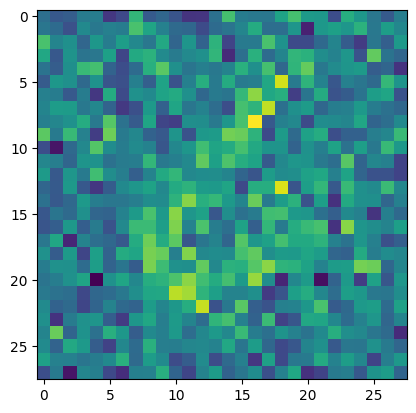

In [24]:
curr_img = 1
rectified_flow_2.v_model.eval()
samples = torch.randn(train_dataset_target.shape)[:100].to(device) * 1/3
#samples = train_dataset_target[:100].to(device)
img = rectified_flow_2.sample_ode(samples, 100)
print("--initial:")
print(torch.mean(samples))
print(torch.std(samples))
print("--target:")
print(torch.mean(train_dataset_target))
print(torch.std(train_dataset_target))
print("--learned:")
print(torch.mean(img[-1][:]))
print(torch.std(img[-1][:]))
plt.imshow(img[-1][curr_img].reshape(28,28).detach().cpu().numpy())
print(img[-1][curr_img].reshape(28,28))
plt.show()

In [23]:
train_dataset_init=(normal_init.sample([num_samples_train]).to(device).reshape(-1, 32*32))
train_dataset_init = torch.where(train_dataset_init < -1, -1, train_dataset_init)
train_dataset_init = torch.where(train_dataset_init > 1, 1, train_dataset_init)

flow_2 = rectified_flow_1.sample_ode(train_dataset_init, 100)
pairs_3 = torch.stack([train_dataset_init, flow_2[-1]], axis=1)

In [24]:
v_mod_3 = v_model(input_dim=32*32,layers=11, hidden_num=32*32)
rectified_flow_3 = RectifiedFlow(v_mod_3)

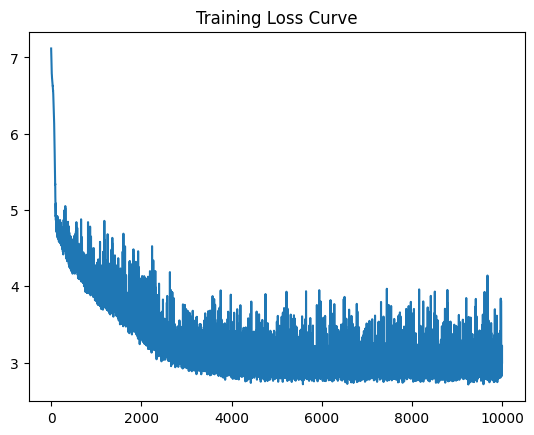

In [25]:
optimizer_3 = torch.optim.Adam(rectified_flow_3.v_model.parameters(), lr=5e-4)
scheduler_3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_3, factor=0.8, patience=100, verbose=False)

rectified_flow_3, loss_curve_3 = train_rectified_flow(rectified_flow_3, optimizer_3, scheduler_3, pairs_3,batchsize=256, iterations=10000)
plt.plot(np.log(loss_curve_3))
plt.title("Training Loss Curve")
plt.show()

15.070207595825195


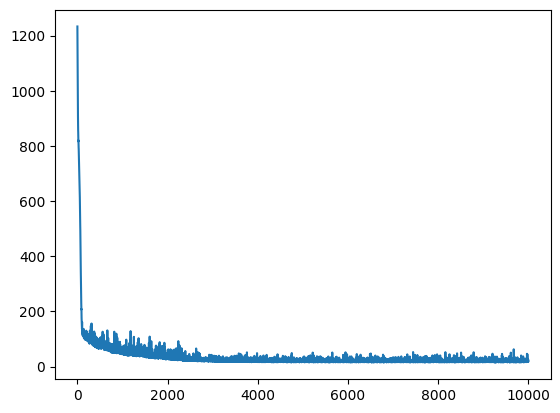

In [33]:
plt.plot(rectified_flow_3.loss_curve)
print(np.min(rectified_flow_3.loss_curve))

tensor(-2.7589e-06, device='cuda:0')
tensor(0.3837, device='cuda:0')
tensor(-0.7236, device='cuda:0')
tensor(0.6867, device='cuda:0')
tensor(-0.7215, device='cuda:0')
tensor(0.7136, device='cuda:0')


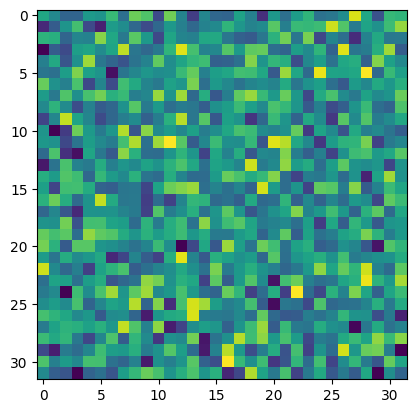

tensor([[-0.7906, -1.1570, -1.4368,  ..., -1.5343, -0.7682, -0.7831],
        [-1.8592, -1.4780, -1.0100,  ..., -1.0509, -0.7742, -0.2964],
        [-0.7065, -0.8683, -1.3319,  ..., -0.7738, -1.3061, -1.2007],
        ...,
        [-1.6459, -1.9249, -1.2188,  ..., -0.5182, -1.2136, -2.0994],
        [-0.6401, -1.0866, -0.9681,  ..., -1.5221, -0.6041, -0.8382],
        [-1.1200, -1.4253, -1.4898,  ..., -2.1351, -1.0705, -1.4336]],
       device='cuda:0')


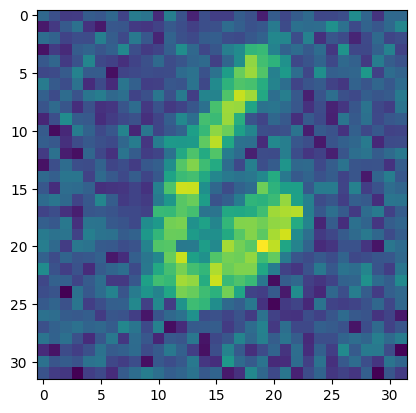

tensor([[-0.7800, -1.1150, -1.3396,  ..., -1.5107, -0.6102, -0.5313],
        [-1.7045, -1.4496, -0.9365,  ..., -0.8517, -0.4875, -0.2488],
        [-0.6561, -0.7611, -1.3110,  ..., -0.7725, -1.2206, -1.1557],
        ...,
        [-1.6735, -1.7999, -1.1850,  ..., -0.4690, -1.2142, -1.9984],
        [-0.6250, -1.1556, -0.8988,  ..., -1.4504, -0.5471, -0.7328],
        [-1.1524, -1.3243, -1.4888,  ..., -2.0607, -1.0458, -1.3645]],
       device='cuda:0')


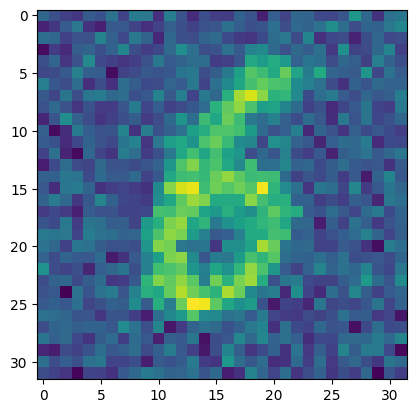

In [31]:
curr_img = 9
img = rectified_flow_2.sample_ode(pairs_3[:10, 0], 100)
print(torch.mean(pairs_3[:, 0]))
print(torch.std(pairs_3[:, 0]))
print(torch.mean(pairs_3[:, 1]))
print(torch.std(pairs_3[:, 1]))
print(torch.mean(img[-1][:]))
print(torch.std(img[-1][:]))
plt.imshow(pairs_3[curr_img, 0].reshape(32,32).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(32,32).detach().cpu().numpy())
print(img[-1][curr_img].reshape(32,32))
plt.show()
plt.imshow(pairs_3[curr_img, 1].reshape(32,32).detach().cpu().numpy())
print(pairs_3[curr_img, 1].reshape(32,32))
plt.show()